In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.patches import Patch

#**1. DATA UNDERSTANDING**

**Keterangan Variabel**

* Y  : Rata-rata pengeluaran untuk rokok dan tembakau per minggu (Ribu rupiah)
* X1 : Persentase Pengeluaran per Kapita Ribu rupiah (%)
* X2 : PDRB perkapita (Ribu rupiah)
* X3 : Jumlah Penduduk (Ribu jiwa)
* X4 : Jumlah Penduduk Miskin (Ribu rupiah)
* X5 : Rata-Rata Lama Sekolah (Tahun)


In [38]:
data = pd.read_excel("/content/Data Pelatihan.xlsx")
data

,Tahun,Provinsi,Kabupaten/Kota,LAT,LONG,Y,X1,X2,X3,X4,X5
0,2024,Banten,Pandeglang,-6.316667,106.116667,23547.00,60.87,27078,1326.0,113.45,7.65
1,2024,Banten,Lebak,-6.566667,106.066667,32877.00,65.01,25967,1449.2,111.71,7.08
2,2024,Banten,Tangerang,-6.166667,106.633333,27095.00,52.81,54729,3400.5,266.43,9.48
3,2024,Banten,Serang,-6.116667,106.150000,31448.00,57.86,60007,1701.8,68.86,8.32
4,2024,Banten,Kota Tangerang,-6.166667,106.616667,26119.00,45.26,114458,1964.0,128.91,11.52
...,...,...,...,...,...,...,...,...,...,...,...
352,2022,Jawa Timur,Kota Pasuruan,-7.633333,112.900000,17286.38,48.47,44303,209.5,13.07,10.18
353,2022,Jawa Timur,Kota Mojokerto,-7.466667,112.433333,14044.42,44.12,56648,133.3,7.43,11.43
354,2022,Jawa Timur,Kota Madiun,-7.616667,111.533333,12375.33,43.49,79817,196.9,7.84,12.08
355,2022,Jawa Timur,Kota Surabaya,-7.250000,112.783333,16035.81,41.60,226080,2880.3,116.62,11.04


In [39]:
data.head(5)

,Tahun,Provinsi,Kabupaten/Kota,LAT,LONG,Y,X1,X2,X3,X4,X5
0,2024,Banten,Pandeglang,-6.316667,106.116667,23547.0,60.87,27078,1326.0,113.45,7.65
1,2024,Banten,Lebak,-6.566667,106.066667,32877.0,65.01,25967,1449.2,111.71,7.08
2,2024,Banten,Tangerang,-6.166667,106.633333,27095.0,52.81,54729,3400.5,266.43,9.48
3,2024,Banten,Serang,-6.116667,106.150000,31448.0,57.86,60007,1701.8,68.86,8.32
4,2024,Banten,Kota Tangerang,-6.166667,106.616667,26119.0,45.26,114458,1964.0,128.91,11.52


In [40]:
data.tail(5)

,Tahun,Provinsi,Kabupaten/Kota,LAT,LONG,Y,X1,X2,X3,X4,X5
352,2022,Jawa Timur,Kota Pasuruan,-7.633333,112.900000,17286.38,48.47,44303,209.5,13.07,10.18
353,2022,Jawa Timur,Kota Mojokerto,-7.466667,112.433333,14044.42,44.12,56648,133.3,7.43,11.43
354,2022,Jawa Timur,Kota Madiun,-7.616667,111.533333,12375.33,43.49,79817,196.9,7.84,12.08
355,2022,Jawa Timur,Kota Surabaya,-7.250000,112.783333,16035.81,41.60,226080,2880.3,116.62,11.04
356,2022,Jawa Timur,Kota Batu,-7.866667,112.533333,19090.34,47.22,85414,214.7,6.59,9.91


In [41]:
data.shape

(357, 11)

In [42]:
data.dtypes

,0
Tahun,int64
Provinsi,object
Kabupaten/Kota,object
LAT,float64
LONG,float64
Y,float64
X1,float64
X2,int64
X3,float64
X4,float64


#**2. DATA CLEANING**

### MEMERIKSA MISSING VALUES

In [43]:
data.isnull().sum()

,0
Tahun,0
Provinsi,0
Kabupaten/Kota,0
LAT,0
LONG,0
Y,0
X1,0
X2,0
X3,0
X4,0


### MEMERIKSA NILAI DUPLIKAT

In [44]:
print("\nJumlah baris duplikat:")
print(data
      .duplicated().sum())


Jumlah baris duplikat:
0


#**3. EXPLORATORY DATA ANALYSIS (EDA)**

In [45]:
data.describe()

,Tahun,LAT,LONG,Y,X1,X2,X3,X4,X5
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,3.570000e+02,357.000000,357.000000
mean,2023.000000,-7.164846,109.951821,19965.623333,50.544986,75091.512605,1.183364e+04,114.044146,9.112157
std,0.817643,0.591259,2.288326,5045.782381,6.644540,103388.697470,9.533860e+04,74.120845,1.577761
min,2022.000000,-8.216667,105.966667,7911.530000,32.120000,19876.000000,2.850000e+01,3.470000,5.560000
25%,2022.000000,-7.633333,107.900000,16219.000000,45.270000,30627.000000,7.882000e+02,69.940000,7.930000
50%,2023.000000,-7.200000,110.216667,19496.860000,51.930000,39699.000000,1.145900e+03,106.480000,8.680000
75%,2024.000000,-6.816667,111.900000,22954.570000,54.920000,72528.000000,1.708800e+03,147.330000,10.170000
max,2024.000000,-5.616667,114.400000,37061.100000,65.380000,883715.000000,1.147562e+06,474.740000,12.380000


In [46]:
numerical_col = ["Y","X1","X2","X3","X4","X5"]

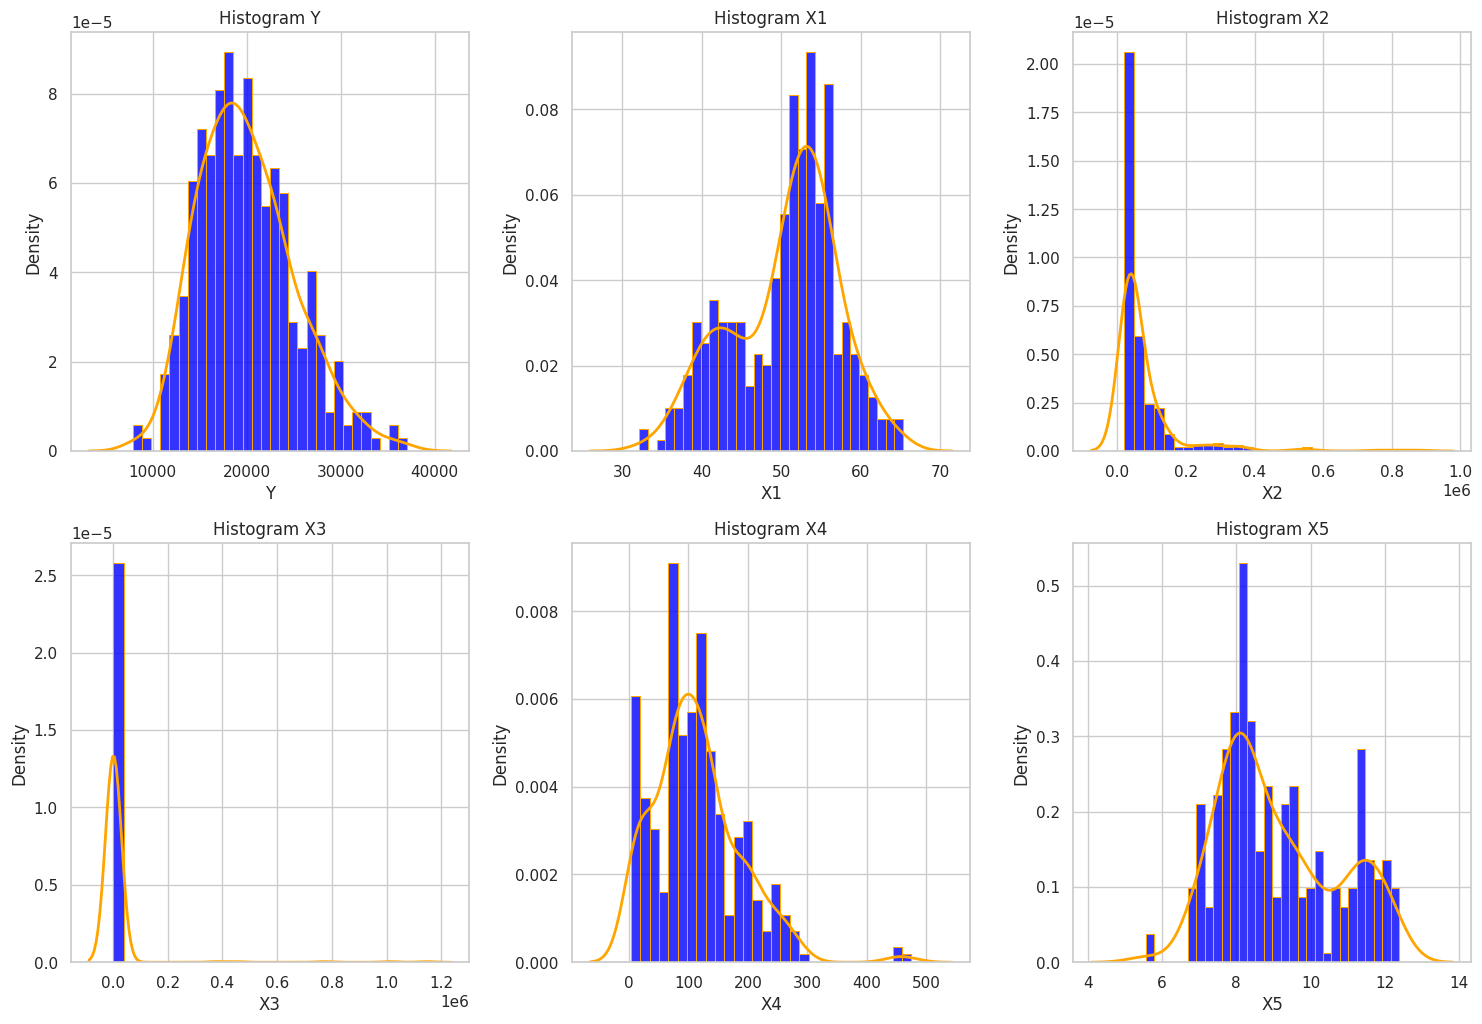

In [47]:
plt.figure(figsize=(15, 15))
for i, column in enumerate(numerical_col, start=1):
    ax = plt.subplot(3, 3, i)
    vals = data[column].dropna()
    sns.histplot(
        vals,
        bins=30,
        kde=False,
        color="blue",
        edgecolor="orange",
        alpha= 0.8,
        stat="density"
    )
    sns.kdeplot(
        vals,
        color="orange",
        linewidth=2
    )

    ax.set_title(f"Histogram {column}")
    ax.set_xlabel(column)
plt.tight_layout()
plt.show()

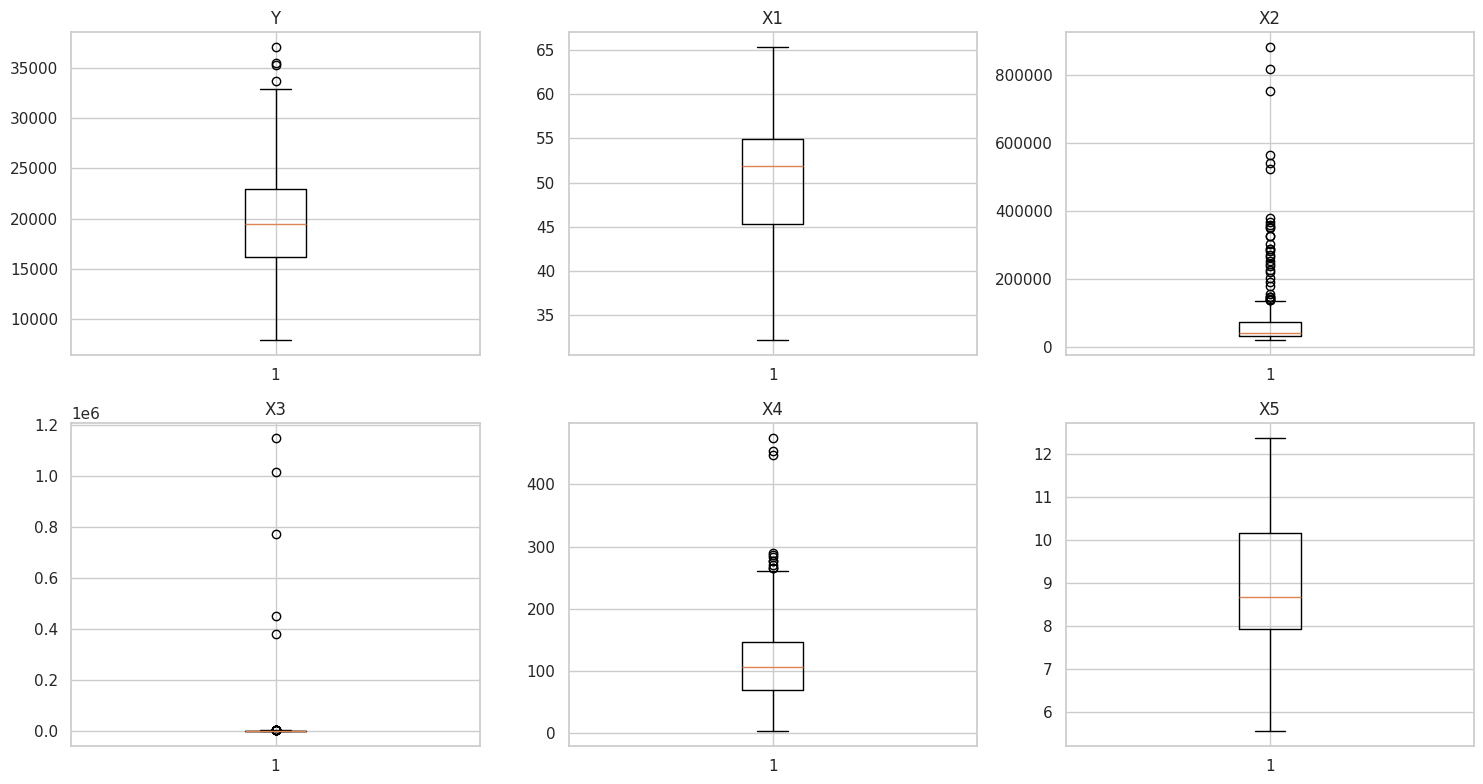

In [48]:
num_variables = len(numerical_col)
num_rows = 2
num_cols = (num_variables + num_rows - 1) // num_rows

plt.figure(figsize=(15, 8))

for i, variable in enumerate(numerical_col):
    plt.subplot(num_rows, num_cols, i+1)
    plt.boxplot(data[variable], whis=1.5)
    plt.title(variable)

plt.tight_layout()
plt.show()

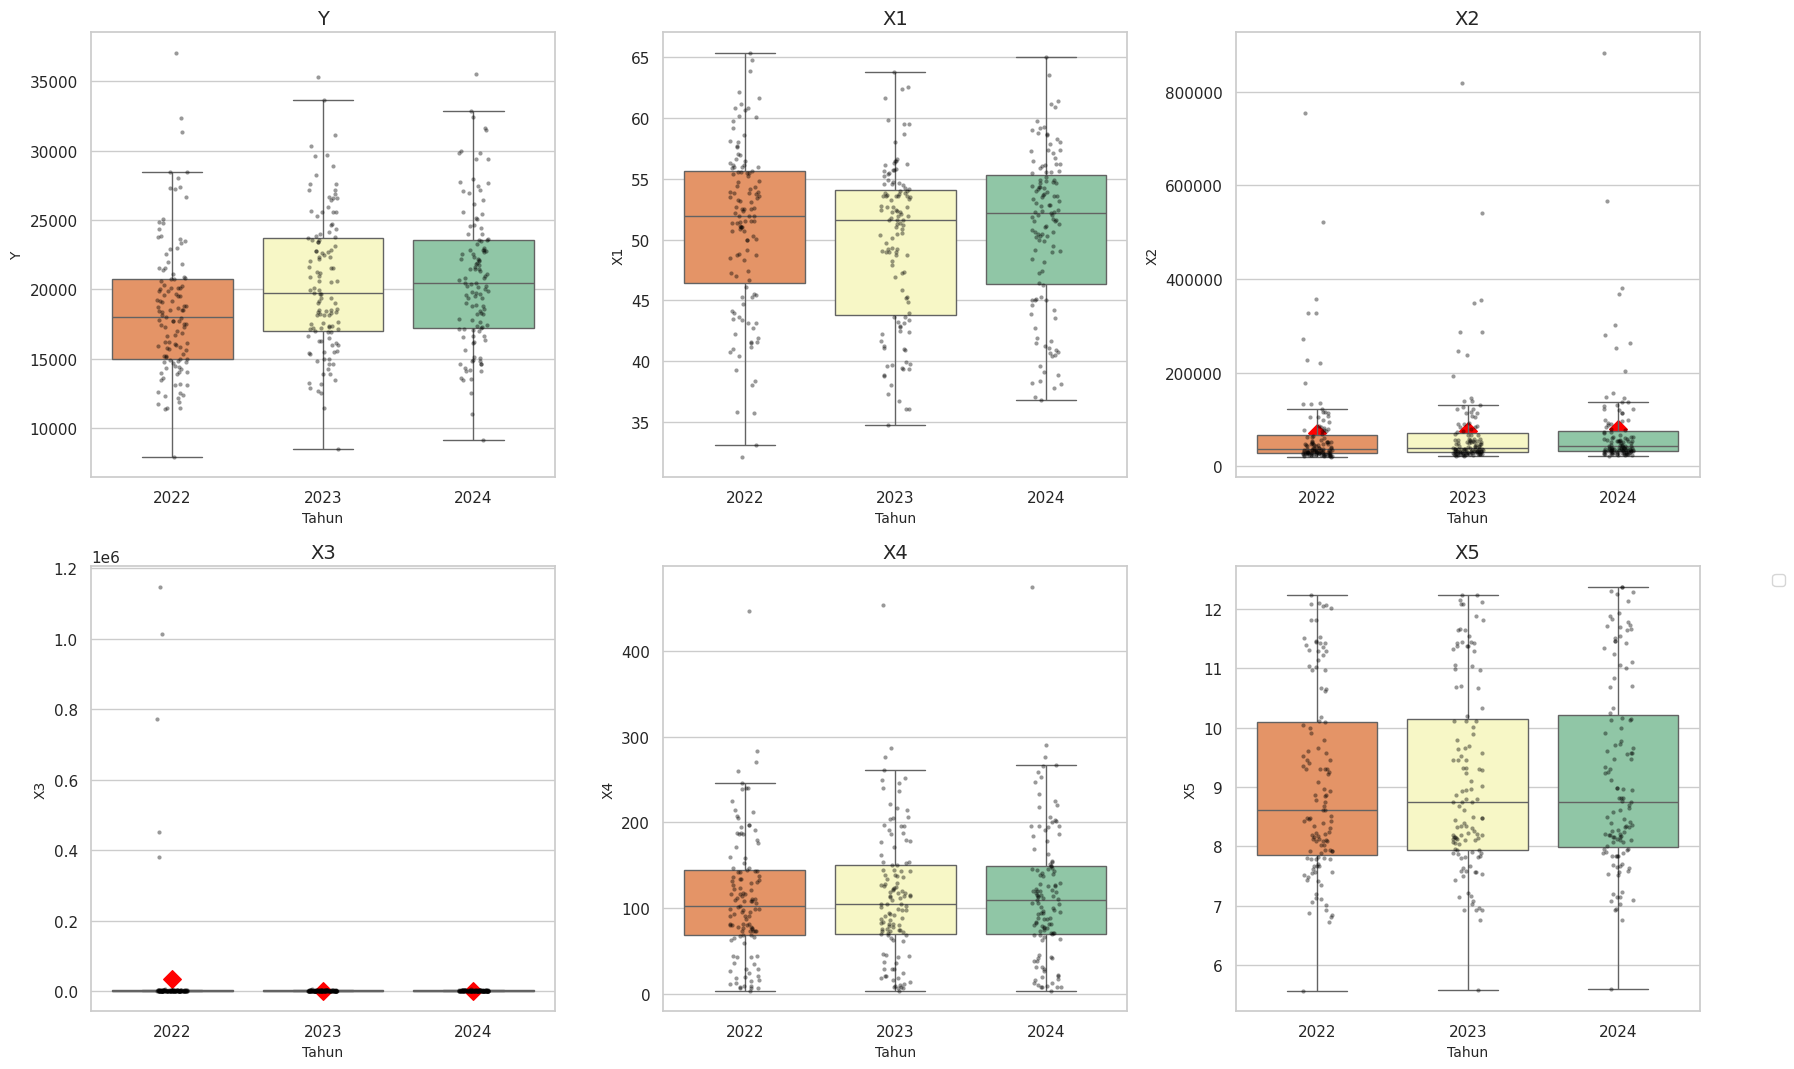

In [49]:
sns.set_theme(style="whitegrid", palette="Spectral")
plt.figure(figsize=(18, 12))
for i, column in enumerate(numerical_col, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(
        x="Tahun",
        y=column,
        data=data,
        palette="Spectral",
        showfliers=False
    )
    sns.stripplot(
        x="Tahun",
        y=column,
        data=data,
        color="black",
        jitter=True,
        alpha=0.4,
        size=3
    )

    means = data.groupby("Tahun")[column].mean()
    for j, year in enumerate(sorted(data["Tahun"].unique())):
        plt.scatter(
            j, means.loc[year],
            color="red",
            s=80,
            marker="D",
            label="Mean" if i == 1 and j == 0 else ""
        )

    plt.title(f"{column}", fontsize=14)
    plt.xlabel("Tahun", fontsize=10)
    plt.ylabel(column, fontsize=10)

# Tambahkan legenda untuk mean sekali saja
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))

plt.suptitle("", fontsize=18, weight="bold")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


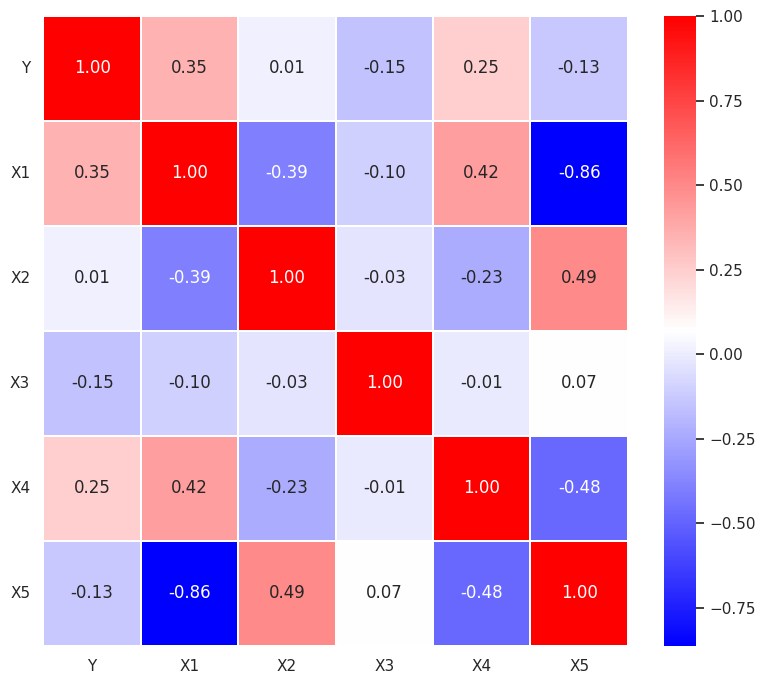

In [50]:
cols = [c for c in ["Y","X1","X2","X3","X4","X5"] if c in data.columns]
plt.figure(figsize=(8,7))
sns.heatmap(data[cols].corr(), cmap="bwr", annot=True, fmt=".2f", linewidths=.2)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

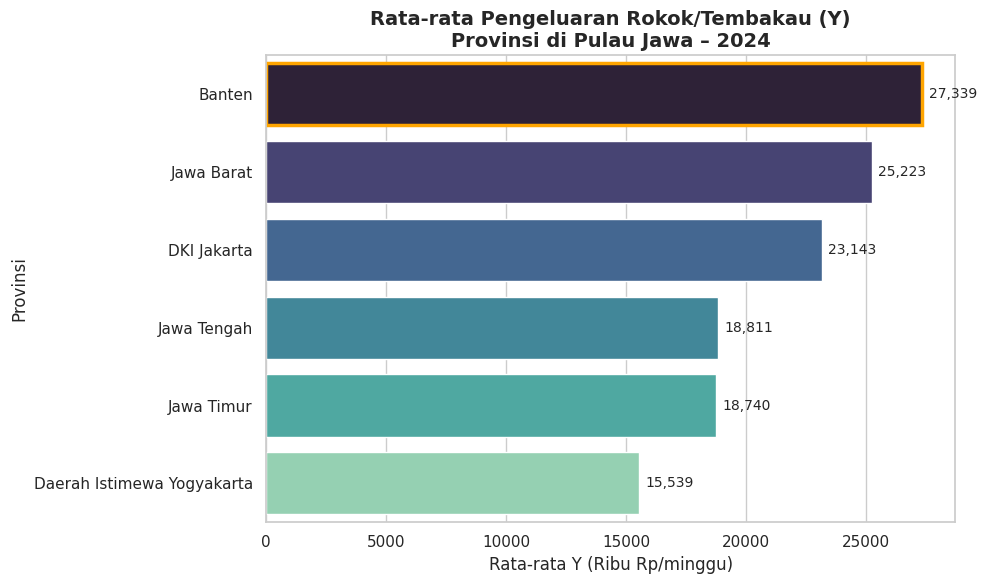

In [51]:
java_provinces = [
    "Banten",
    "DKI Jakarta",
    "Jawa Barat",
    "Jawa Tengah",
    "Daerah Istimewa Yogyakarta",
    "Jawa Timur",
]

df_java_2024 = (
    data.query("Tahun == 2024 and Provinsi in @java_provinces")
         .copy()
)
prov_rank = (df_java_2024
             .groupby("Provinsi", as_index=False)["Y"]
             .mean()
             .sort_values("Y", ascending=False))

top_province = prov_rank.iloc[0, 0]
top_value = prov_rank.iloc[0, 1]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=prov_rank,
    x="Y", y="Provinsi",
    palette="mako"
)
plt.title("Rata-rata Pengeluaran Rokok/Tembakau (Y)\nProvinsi di Pulau Jawa – 2024", fontsize=14, weight="bold")
plt.xlabel("Rata-rata Y (Ribu Rp/minggu)")
plt.ylabel("Provinsi")

for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax.text(w + (0.01*prov_rank["Y"].max()), y, f"{w:,.0f}", va="center", fontsize=10)

for p in ax.patches:
    if p.get_y() + p.get_height()/2 in ax.get_yticks():
        label = ax.get_yticklabels()[list(ax.get_yticks()).index(p.get_y() + p.get_height()/2)].get_text()
        if label == top_province:
            p.set_edgecolor("orange")
            p.set_linewidth(2.5)

plt.tight_layout()
plt.show()

In [52]:
import geopandas as gpd
# --- Load geojson ---
geo_path = "/content/indonesia-province.json"
gdf = gpd.read_file(geo_path)

# --- Tampilkan semua kolom ---
print("\n=== Kolom tersedia di geojson ===")
print(gdf.columns.tolist())

# --- Cek isi 5 baris pertama ---
print("\n=== 5 baris pertama ===")
print(gdf.head())

# --- Cek kolom string dan 10 nilai unik pertama ---
print("\n=== Nilai unik dari kolom string ===")
for c in gdf.columns:
    if gdf[c].dtype == "object":
        print(f"\nKolom: {c}")
        print(gdf[c].unique()[:10])


=== Kolom tersedia di geojson ===
['ID', 'kode', 'Propinsi', 'SUMBER', 'geometry']

=== 5 baris pertama ===
   ID  kode                    Propinsi  \
0   1    85            IRIAN JAYA TIMUR   
1   2    52          NUSATENGGARA BARAT   
2   3    75                   GORONTALO   
3   4    74           SULAWESI TENGGARA   
4   5    34  DAERAH ISTIMEWA YOGYAKARTA   

                                      SUMBER  \
0  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   
1  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   
2  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   
3  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   
4  Peta Dasar BAKOSURTANAL Skala 1 : 250.000   

                                            geometry  
0  MULTIPOLYGON (((137.91666 -1.49852, 137.8926 -...  
1  MULTIPOLYGON (((117.6272 -8.5064, 117.6263 -8....  
2  MULTIPOLYGON (((122.18814 1.0453, 122.18883 1....  
3  MULTIPOLYGON (((120.98423 -2.83534, 120.98502 ...  
4  POLYGON ((110.01183 -7.8869, 110.0133 -7.88587...  

=== Nilai un

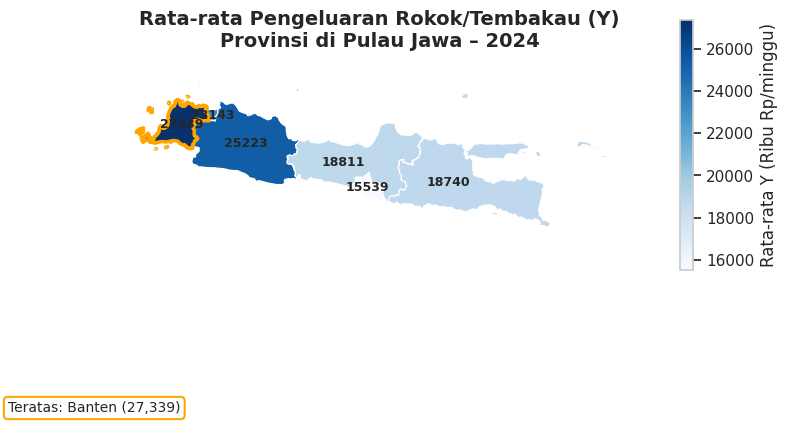

In [53]:
# --- 1) Import ---
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- 2) Data rata-rata Y per provinsi ---
java_provinces = [
    "Banten",
    "DKI Jakarta",
    "Jawa Barat",
    "Jawa Tengah",
    "Daerah Istimewa Yogyakarta",
    "Jawa Timur",
]

# fungsi normalisasi nama provinsi
def norm_prov(s: str) -> str:
    s = str(s).strip().upper()
    if "YOGYAKARTA" in s:
        return "Daerah Istimewa Yogyakarta"
    if "JAKARTA" in s or "DKI" in s:
        return "DKI Jakarta"
    if "BANTEN" in s:
        return "Banten"
    if "JAWA BARAT" in s:
        return "Jawa Barat"
    if "JAWA TENGAH" in s:
        return "Jawa Tengah"
    if "JAWA TIMUR" in s:
        return "Jawa Timur"
    return s.title()

# hitung rata-rata Y provinsi Jawa
df_java_2024 = data.query("Tahun == 2024 and Provinsi in @java_provinces").copy()
prov_rank = (df_java_2024.groupby("Provinsi", as_index=False)["Y"]
             .mean().sort_values("Y", ascending=False))

# normalisasi nama di prov_rank juga
prov_rank["Provinsi"] = prov_rank["Provinsi"].map(norm_prov)

top_province = prov_rank.iloc[0, 0]
top_value    = prov_rank.iloc[0, 1]

# --- 3) Load geojson ---
geo_path = "/content/indonesia-province.json"
gdf = gpd.read_file(geo_path)

# pakai kolom Propinsi dan normalisasi
gdf["Provinsi"] = gdf["Propinsi"].map(norm_prov)

# --- 4) Ambil provinsi Jawa dan merge nilai Y ---
gdf_java = gdf[gdf["Provinsi"].isin(java_provinces)].copy()
gdf_plot = gdf_java.merge(prov_rank, on="Provinsi", how="left")

# --- 5) Plot choropleth ---
fig, ax = plt.subplots(figsize=(8, 5))

gdf_plot.plot(
    column="Y",
    cmap="Blues",
    linewidth=0.8,
    edgecolor="white",
    legend=True,
    legend_kwds={"label": "Rata-rata Y (Ribu Rp/minggu)", "shrink": 0.6},
    ax=ax
)

# highlight provinsi tertinggi
subset = gdf_plot[gdf_plot["Provinsi"] == top_province]
if not subset.empty:
    subset.boundary.plot(ax=ax, color="orange", linewidth=2.5)

# label nilai di representative point
for _, r in gdf_plot.iterrows():
    if r["geometry"] is None or r["geometry"].is_empty:
        continue
    pt = r.geometry.representative_point()
    ax.text(pt.x, pt.y, f"{r['Y']:.0f}", ha="center", va="center",
            fontsize=9, weight="bold")

# judul & anotasi
ax.set_title(
    "Rata-rata Pengeluaran Rokok/Tembakau (Y)\nProvinsi di Pulau Jawa – 2024",
    fontsize=14, weight="bold"
)
ax.set_axis_off()

ax.annotate(
    f"Teratas: {top_province} ({top_value:,.0f})",
    xy=(0.01, 0.02), xycoords="figure fraction",
    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="orange", lw=1.5)
)

plt.tight_layout()
plt.show()

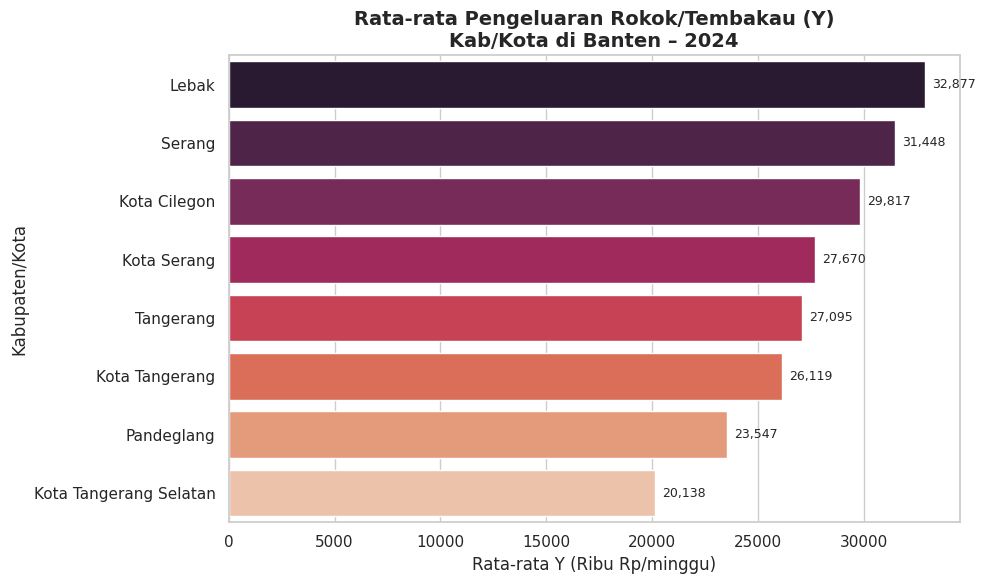

In [54]:
df_top = df_java_2024.query("Provinsi == @top_province")
kabkot_rank = (df_top
               .groupby(["Provinsi", "Kabupaten/Kota"], as_index=False)["Y"]
               .mean()
               .sort_values("Y", ascending=False))
plt.figure(figsize=(10, max(6, 0.35*len(kabkot_rank))))
ax2 = sns.barplot(
    data=kabkot_rank,
    x="Y", y="Kabupaten/Kota",
    palette="rocket"
)
plt.title(f"Rata-rata Pengeluaran Rokok/Tembakau (Y)\nKab/Kota di {top_province} – 2024", fontsize=14, weight="bold")
plt.xlabel("Rata-rata Y (Ribu Rp/minggu)")
plt.ylabel("Kabupaten/Kota")

for p in ax2.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    ax2.text(w + (0.01*kabkot_rank["Y"].max()), y, f"{w:,.0f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

#**4. MODELLING & EVALUATION**

In [55]:
# Pisahkan fitur (variabel X) & target (variabel y)
X = data[["X1","X2","X3","X4","X5"]]
y = data["Y"].astype(float)

In [56]:
# splitting data 80% data training dan 20% data testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [57]:
#STANDARISASI
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled  = scaler.transform(X_test)

In [58]:
# NORMALISASI
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## **METODE RANDOM FOREST**

MAE : 2,578.40
R²  : 0.5164


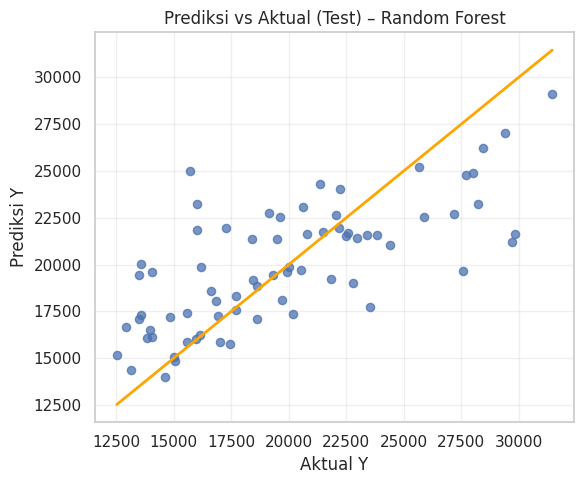

In [59]:
# === 1) Model Random Forest ===
model = RandomForestRegressor(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
    max_features="sqrt"
)
model.fit(X_train_scaled, y_train)

# === 2) Prediksi & Evaluasi ===
y_pred = model.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.4f}")

# === 3) Visual: Prediksi vs Aktual (Scatter + garis 45°) ===
hasil = pd.DataFrame({"Aktual": y_test.values, "Prediksi": y_pred}, index=X_test.index)

plt.figure(figsize=(6,5))
plt.scatter(hasil["Aktual"], hasil["Prediksi"], s=35, alpha=0.75)
lo = min(hasil["Aktual"].min(), hasil["Prediksi"].min())
hi = max(hasil["Aktual"].max(), hasil["Prediksi"].max())
plt.plot([lo, hi], [lo, hi], color="orange", linewidth=2)  # garis ideal
plt.title("Prediksi vs Aktual (Test) – Random Forest")
plt.xlabel("Aktual Y"); plt.ylabel("Prediksi Y")
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()


Tabel Feature Importance:
    Importance
X1    0.305516
X3    0.210506
X4    0.174435
X5    0.159331
X2    0.150213
------------------------------


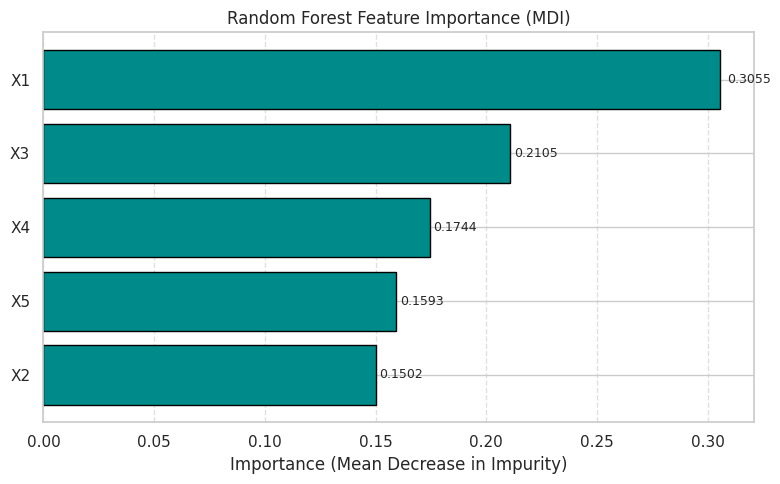

In [60]:
feature_names = list(X.columns)

# --- 1) Ambil Feature Importance dari model Random Forest ---
# Atribut .feature_importances_ berisi nilai MDI (Mean Decrease in Impurity)
importances = model.feature_importances_

# --- 2) Buat tabel ringkas menggunakan pandas Series ---
imp_series = pd.Series(importances, index=feature_names)
imp_table = pd.DataFrame({
    "Importance": imp_series
}).sort_values("Importance", ascending=False)

print("Tabel Feature Importance:")
print(imp_table)
print("-" * 30)


# --- 3) Plot horizontal (lebih informatif) ---
# Urutkan nilai agar plot lebih rapi (dari terkecil ke terbesar)
imp_plot = imp_series.sort_values(ascending=True)

plt.figure(figsize=(8, 5))
bars = plt.barh(imp_plot.index, imp_plot.values, color="darkcyan", edgecolor="black")

# Menambahkan label nilai di ujung setiap bar
for bar in bars:
    width = bar.get_width()
    plt.text(width * 1.01,  # Posisi x sedikit di kanan bar
             bar.get_y() + bar.get_height() / 2, # Posisi y di tengah bar
             f'{width:.4f}', # Format teks
             ha='left',
             va='center',
             fontsize=9)

plt.title("Random Forest Feature Importance (MDI)")
plt.xlabel("Importance (Mean Decrease in Impurity)")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [62]:
# === MENU INPUT X1–X5 → PREDIKSI Y (Jupyter) ===
# Jika ipywidgets belum ada, jalankan:  # !pip install ipywidgets
import ipywidgets as w
from IPython.display import display

feature_names = ["X1","X2","X3","X4","X5"]

# Ringkasan rentang & median berdasarkan data latih (membantu mengisi nilai yang masuk akal)
mins = X_train[feature_names].min()
maxs = X_train[feature_names].max()
meds = X_train[feature_names].median()

# Widget input (diinisialisasi ke median pelatihan)
w_X1 = w.FloatText(value=float(meds["X1"]), description="X1", layout=w.Layout(width="280px"))
w_X2 = w.FloatText(value=float(meds["X2"]), description="X2", layout=w.Layout(width="280px"))
w_X3 = w.FloatText(value=float(meds["X3"]), description="X3", layout=w.Layout(width="280px"))
w_X4 = w.FloatText(value=float(meds["X4"]), description="X4", layout=w.Layout(width="280px"))
w_X5 = w.FloatText(value=float(meds["X5"]), description="X5", layout=w.Layout(width="280px"))
inputs = [w_X1, w_X2, w_X3, w_X4, w_X5]

btn_predict = w.Button(description="Prediksi Y", button_style="success", icon="calculator")
btn_reset   = w.Button(description="Reset ke Median", icon="refresh")
out = w.Output()

def _prediksi(_=None):
    # Kumpulkan nilai, scaling dengan scaler yg sudah fit, lalu prediksi dengan model
    vals = [[w_X1.value, w_X2.value, w_X3.value, w_X4.value, w_X5.value]]
    df_new = pd.DataFrame(vals, columns=feature_names)
    X_new_scaled = scaler.transform(df_new)
    y_hat = float(model.predict(X_new_scaled)[0])

    with out:
        out.clear_output()
        display(pd.DataFrame({
            "Fitur": feature_names,
            "Nilai": [w.value for w in inputs],
            "Min(latih)": [mins[f] for f in feature_names],
            "Max(latih)": [maxs[f] for f in feature_names],
        }))
        print(f"Perkiraan Y: {y_hat:,.2f} (ribu Rp/minggu)")

def _reset(_=None):
    for f, wdg in zip(feature_names, inputs):
        wdg.value = float(meds[f])
    with out:
        out.clear_output()

btn_predict.on_click(_prediksi)
btn_reset.on_click(_reset)

title = w.HTML("<h3>Menu Prediksi Y</h3><p>Isi X1–X5 lalu klik <b>Prediksi Y</b>. "
               "Rentang yang ditampilkan berasal dari data latih.</p>")

ui = w.VBox([
    title,
    w.HBox([w_X1, w_X2]),
    w.HBox([w_X3, w_X4]),
    w.HBox([w_X5]),
    w.HBox([btn_predict, btn_reset]),
    out
])

display(ui)

##**METODE XGBOOST**

MAE : 2,443.99
R²  : 0.5589


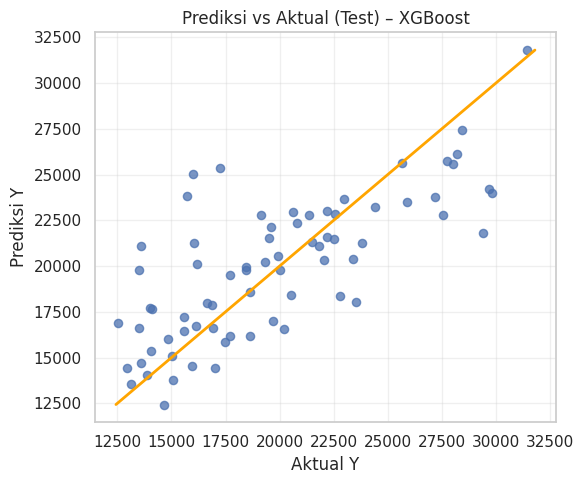

In [63]:
# === 1) Model XGBoost ===
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"   # cepat
)
xgb.fit(X_train_scaled, y_train)

# === 2) Prediksi & Evaluasi ===
y_pred = xgb.predict(X_test_scaled)

mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.4f}")

# === 3) Visual: Prediksi vs Aktual (Scatter + garis 45°) ===
hasil = pd.DataFrame({"Aktual": y_test.values, "Prediksi": y_pred}, index=X_test.index)

plt.figure(figsize=(6,5))
plt.scatter(hasil["Aktual"], hasil["Prediksi"], s=35, alpha=0.75)
lo = min(hasil["Aktual"].min(), hasil["Prediksi"].min())
hi = max(hasil["Aktual"].max(), hasil["Prediksi"].max())
plt.plot([lo, hi], [lo, hi], color="orange", linewidth=2)  # garis ideal
plt.title("Prediksi vs Aktual (Test) – XGBoost")
plt.xlabel("Aktual Y"); plt.ylabel("Prediksi Y")
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()

            Gain     Split
X3  1.776568e+06  0.267577
X5  1.627860e+06  0.245179
X1  1.187036e+06  0.178785
X4  1.121720e+06  0.168947
X2  9.262889e+05  0.139512


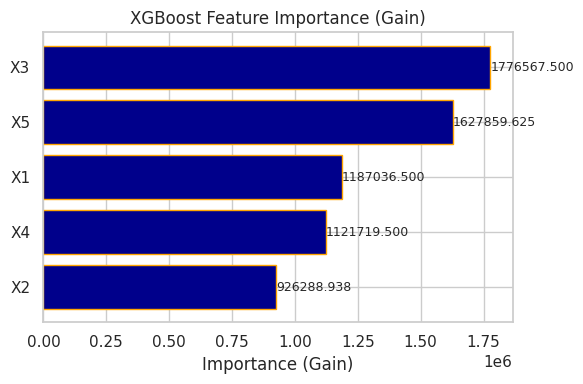

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# --- nama fitur asli (sebelum scaling) ---
feature_names = list(X.columns)  # ["X1","X2","X3","X4","X5"]

# --- 1) Importance versi 'gain' (lebih informatif) ---
gain_dict = xgb.get_booster().get_score(importance_type="gain")  # keys: 'f0','f1',...
gain_series = pd.Series({feature_names[int(k[1:])]: v for k, v in gain_dict.items()})
gain_series = gain_series.reindex(feature_names).fillna(0.0)

# --- 2) (Opsional) Importance bawaan (split frequency) ---
split_series = pd.Series(xgb.feature_importances_, index=feature_names)

# Tabel ringkas
imp_table = pd.DataFrame({
    "Gain": gain_series,
    "Split": split_series
}).sort_values("Gain", ascending=False)
print(imp_table)

# --- Plot horizontal (pakai 'Gain') ---
imp_plot = gain_series.sort_values(ascending=True)
plt.figure(figsize=(6,4))
plt.barh(imp_plot.index, imp_plot.values, color="darkblue", edgecolor="orange")
for i, v in enumerate(imp_plot.values):
    plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=9)
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()

In [65]:
# === MENU INPUT X1–X5 → PREDIKSI Y (Jupyter) ===
# Jika ipywidgets belum ada, jalankan:  # !pip install ipywidgets
import ipywidgets as w
from IPython.display import display

feature_names = ["X1","X2","X3","X4","X5"]

# Ringkasan rentang & median berdasarkan data latih (membantu mengisi nilai yang masuk akal)
mins = X_train[feature_names].min()
maxs = X_train[feature_names].max()
meds = X_train[feature_names].median()

# Widget input (diinisialisasi ke median pelatihan)
w_X1 = w.FloatText(value=float(meds["X1"]), description="X1", layout=w.Layout(width="280px"))
w_X2 = w.FloatText(value=float(meds["X2"]), description="X2", layout=w.Layout(width="280px"))
w_X3 = w.FloatText(value=float(meds["X3"]), description="X3", layout=w.Layout(width="280px"))
w_X4 = w.FloatText(value=float(meds["X4"]), description="X4", layout=w.Layout(width="280px"))
w_X5 = w.FloatText(value=float(meds["X5"]), description="X5", layout=w.Layout(width="280px"))
inputs = [w_X1, w_X2, w_X3, w_X4, w_X5]

btn_predict = w.Button(description="Prediksi Y", button_style="success", icon="calculator")
btn_reset   = w.Button(description="Reset ke Median", icon="refresh")
out = w.Output()

def _prediksi(_=None):
    # Kumpulkan nilai, scaling dengan scaler yg sudah fit, lalu prediksi dengan model
    vals = [[w_X1.value, w_X2.value, w_X3.value, w_X4.value, w_X5.value]]
    df_new = pd.DataFrame(vals, columns=feature_names)
    X_new_scaled = scaler.transform(df_new)
    y_hat = float(xgb.predict(X_new_scaled)[0])

    with out:
        out.clear_output()
        display(pd.DataFrame({
            "Fitur": feature_names,
            "Nilai": [w.value for w in inputs],
            "Min(latih)": [mins[f] for f in feature_names],
            "Max(latih)": [maxs[f] for f in feature_names],
        }))
        print(f"Perkiraan Y: {y_hat:,.2f} (ribu Rp/minggu)")

def _reset(_=None):
    for f, wdg in zip(feature_names, inputs):
        wdg.value = float(meds[f])
    with out:
        out.clear_output()

btn_predict.on_click(_prediksi)
btn_reset.on_click(_reset)

title = w.HTML("<h3>Menu Prediksi Y</h3><p>Isi X1–X5 lalu klik <b>Prediksi Y</b>. "
               "Rentang yang ditampilkan berasal dari data latih.</p>")

ui = w.VBox([
    title,
    w.HBox([w_X1, w_X2]),
    w.HBox([w_X3, w_X4]),
    w.HBox([w_X5]),
    w.HBox([btn_predict, btn_reset]),
    out
])

display(ui)

# **5. CLUSTERING**


## **K-MEANS CLUSTERING**

In [ ]:
!pip install "numpy<2" # di run cukup sekali, setelah itu mulai dari upload dataset dan run sintaks dari panggil package dan import data

In [ ]:
!pip install scikit-learn-extra

In [ ]:
x_train = data[["Y"]].values

In [ ]:
# Elbow method
from sklearn.cluster import KMeans
cs = []
for i in range (1,10):
    kmeans = KMeans(n_clusters=i, init = 'k-means++',max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x_train)
    cs.append(kmeans.inertia_)
plt.plot(range(1,10), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [ ]:
# Silhouette method
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=300)
    kmeans.fit(x_train)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(x_train, cluster_labels)
    print("For n_cluster={0}, the silhoutte score is {1}".format(num_clusters, silhouette_avg))

In [ ]:
# didapat Jumlah k = 2 Terbaik
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans

In [ ]:
y_cluster = kmeans.fit_predict(x_train)

In [ ]:
data['kelas'] = y_cluster

In [ ]:
kmeans.cluster_centers_

In [ ]:
data["kelas"] = data["kelas"].astype("object")

data.loc[data.kelas==0, "kelas"] = "Rendah"
data.loc[data.kelas==1, "kelas"] = "Tinggi"

In [ ]:
data.groupby(["kelas"]).count()

In [ ]:
colors = {'Tinggi': 'red', 'Rendah': 'black'}
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=data,
    x=data.index,
    y='Y',
    hue='kelas',
    palette=colors,
    s=25,
    alpha=0.7
)
plt.title('Scatter Plot Kluster Berdasarkan Nilai Y')
plt.xlabel('Indeks Data')
plt.ylabel('Nilai Y')
plt.legend(title='Kelas')
plt.grid(True, linestyle='--')
plt.show()

## **K-MEDOIDS**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids


x_train = data[["Y"]].values

In [ ]:
# --- Elbow method (menggunakan K-Medoids) ---
cs = []
for i in range (1,10):
    # Menggunakan KMedoids sebagai ganti KMeans
    kmedoids = KMedoids(n_clusters=i, random_state = 0) # <-- DIUBAH
    kmedoids.fit(x_train)
    # K-Medoids tidak punya atribut .inertia_, tapi .inertia_ K-Means
    # adalah jumlah kuadrat jarak. Hal yang setara di K-Medoids adalah .inertia_ juga
    # (walaupun dihitung sedikit berbeda, tujuannya sama).
    cs.append(kmedoids.inertia_)

plt.plot(range(1,10), cs)
plt.title('The Elbow Method for K-Medoids')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [ ]:
# --- Silhouette method (menggunakan K-Medoids) ---
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    # Menggunakan KMedoids sebagai ganti KMeans
    kmedoids = KMedoids(n_clusters=num_clusters, random_state=0) # <-- DIUBAH
    kmedoids.fit(x_train)
    cluster_labels = kmedoids.labels_

    silhouette_avg = silhouette_score(x_train, cluster_labels)
    print("For n_cluster={0}, the silhoutte score is {1}".format(num_clusters, silhouette_avg))

In [ ]:
# --- Terapkan model dengan k terbaik ---
kmedoids = KMedoids(n_clusters = 2, random_state = 0) # <-- DIUBAH
y_cluster2 = kmedoids.fit_predict(x_train)

In [ ]:
data['kelas_2'] = y_cluster2
print("\nPusat Cluster (Medoids):")
print(kmedoids.cluster_centers_) # <-- Ini adalah data point asli

In [ ]:
data["kelas_2"] = data["kelas_2"].astype("object")

data.loc[data.kelas_2==0, "kelas_2"] = "Rendah"
data.loc[data.kelas_2==1, "kelas_2"] = "Tinggi"

In [ ]:
data.groupby(["kelas_2"]).count()

In [ ]:
colors = {'Tinggi': 'red', 'Rendah': 'black'}
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=data,
    x=data.index,
    y='Y',
    hue='kelas_2',
    palette=colors,
    s=25,
    alpha=0.7
)
plt.title('Scatter Plot Kluster K-Medoids')
plt.xlabel('Indeks Data')
plt.ylabel('Nilai Y')
plt.legend(title='Kelas')
plt.grid(True, linestyle='--')
plt.show()

In [ ]:
data

# **6. PETA HASIL CLUSTERING**

In [ ]:
gdf["Provinsi"] = gdf["Propinsi"].map(norm_prov)
gdf_java = gdf[gdf["Provinsi"].isin(java_provinces)].to_crs(4326).copy()

# --- 4) Ambil label kelas per provinsi (pakai modus) ---
kelas_1 = data.groupby("Provinsi")["kelas"].agg(lambda x: x.mode()[0]).reset_index(name="kelas_1")
kelas_2 = data.groupby("Provinsi")["kelas_2"].agg(lambda x: x.mode()[0]).reset_index(name="kelas_2")
gdf_java = gdf_java.merge(kelas_1, on="Provinsi", how="left").merge(kelas_2, on="Provinsi", how="left")

# --- 5) Pemetaan warna ---
color_map = {"Tinggi": "red", "Rendah": "pink"}
legend_patches = [
    Patch(facecolor="red", edgecolor="black", label="Tinggi"),
    Patch(facecolor="pink", edgecolor="black", label="Rendah")
]

# --------------- PLOT 1: kelas_1 (K-Means) ---------------
fig1, ax1 = plt.subplots(figsize=(13,8))
gdf_java.plot(
    ax=ax1,
    color=gdf_java["kelas_1"].map(color_map),
    edgecolor="black", linewidth=0.8
)
for _, r in gdf_java.iterrows():
    pt = r.geometry.representative_point()
    ax1.text(pt.x, pt.y, r["Provinsi"], ha="center", va="center", fontsize=8, weight="bold")
ax1.set_axis_off()
ax1.set_title("Peta Hasil Clustering (K-Means Clustering)", fontsize=13, weight="bold")
ax1.legend(handles=legend_patches, loc="lower left", frameon=True, title="Kategori")
plt.tight_layout()
plt.show()

In [ ]:
# --------------- PLOT 2: kelas_2 (K-Medoids) ---------------
fig2, ax2 = plt.subplots(figsize=(13,8))
gdf_java.plot(
    ax=ax2,
    color=gdf_java["kelas_2"].map(color_map),
    edgecolor="black", linewidth=0.8
)
for _, r in gdf_java.iterrows():
    pt = r.geometry.representative_point()
    ax2.text(pt.x, pt.y, r["Provinsi"], ha="center", va="center", fontsize=8, weight="bold")
ax2.set_axis_off()
ax2.set_title("Peta Hasil Clustering (K-Medoids Clustering)", fontsize=13, weight="bold")
ax2.legend(handles=legend_patches, loc="lower left", frameon=True, title="Kategori")
plt.tight_layout()
plt.show()